In [11]:
!pip install glom

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 97 kB 12.0 MB/s            
     |████████████████████████████████| 46 kB 14.2 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 193 kB 75.2 MB/s            
  Created wheel for face: filename=face-20.1.1-py3-none-any.whl size=51078 sha256=e39e866f4cfa38c01961d967661bafe677302fa7514080903bc886fb016d6e8f
  Stored in directory: /home/mchorse/.cache/pip/wheels/a6/04/6e/762e32505699fc01cc1ba87b9921ab1eb98e98a12954638618
Successfully built face


In [250]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 292 kB 12.8 MB/s            
     |████████████████████████████████| 11.3 MB 30.9 MB/s            
     |████████████████████████████████| 1.2 MB 78.7 MB/s            
     |████████████████████████████████| 4.3 MB 46.2 MB/s            
     |████████████████████████████████| 890 kB 69.8 MB/s            


In [110]:
import glob
import json
import os
import pandas as pd
import re
import seaborn as sns

from collections import OrderedDict
from glom import glom

In [335]:
def rchop(s, suffix):
    if suffix and s.endswith(suffix):
        return s[:-len(suffix)]
    return s

def canonical_model_name(name):
        return rchop(name, "_checkpoints")

    
rgx_toplevel = re.compile("^(.*)_eval_results_.([0-9-]+).json$")
rgx_plain = re.compile("^[^.]+$")
rgx_step = re.compile("(^[^.]+)\.global_step(\d+)$")
rgx_depth = re.compile("^([^.]+)\.extra_linear\.(\d+)$")
rgx_lens = re.compile("^([^.]+)\.final_linear\.(\d+)$")

def parse_results_file_name(file_name):
    res = OrderedDict()
    m = rgx_toplevel.match(file_name)
    if m is None:
        print("WARNING: cannot parse results file '{}'".format(path))
        return None

    run_id = m[1]
    res['path'] = path
    res['timestamp'] = m[2]
    
    m_step = rgx_step.match(run_id)
    if m_step is not None:
        res['model'] = canonical_model_name(m_step[1])
        res['step'] = int(m_step[2])
        return res

    m_depth = rgx_depth.match(run_id)
    if m_depth is not None:
        res['model'] = canonical_model_name(m_depth[1])
        res['layer'] = int(m_depth[2])
        return res

    m_lens = rgx_lens.match(run_id)
    if m_depth is not None:
        res['model'] = canonical_model_name(m_depth[1])
        res['lens'] = int(m_lens[2])
        return res

    m_plain = rgx_plain.match(run_id)
    if m_plain is not None:
        res['model'] = canonical_model_name(m_plain[0])
        return res

    print("WARNING: cannot parse run id '{}'".format(run_id))
    return None

def build_results_df(path):
    dict_list = []
    for file_path in glob.glob(os.path.join(path, "*.json")):
        # Parse the file name and add
        meta = parse_results_file_name(os.path.basename(file_path))

        # Read the json file into a data frame

        with open(file_path) as f:
            result_json = json.load(f)

        records = []
        for benchmark in result_json.keys():
            for metric in result_json[benchmark]:
                record = dict()
                record["benchmark"] = benchmark
                record["metric"] = metric
                record["value"] = result_json[benchmark][metric]

                meta_pos = 0
                for meta_key in meta:
                    record[meta_key] = meta[meta_key]
                dict_list.append(record)

    res = pd.json_normalize(dict_list)
    print(dict_list[0])

    #res = pd.concat(df_list)
    def set_col_type(col_name, t):
        if col_name in res:
            res[col_name] = res[col_name].astype(t)
    set_col_type('path', str)
    set_col_type('model', str)
    set_col_type('step', pd.Int64Dtype())
    set_col_type('layer', pd.Int64Dtype())
    set_col_type('lens', pd.Int64Dtype())
    set_col_type('benchmark', str)
    set_col_type('metric', str)
    set_col_type('value', float)

    return res

In [336]:
r = build_results_df("/mnt/ssd-1/igor/gpt-neox/results")

{'benchmark': 'lambada', 'metric': 'ppl', 'value': 10.965982135507819, 'path': '/mnt/ssd-1/igor/gpt-neox/results/dense_small.extra_linear.*', 'timestamp': '1-14-2022-08-54-50', 'model': 'dense_medium', 'step': 200000}


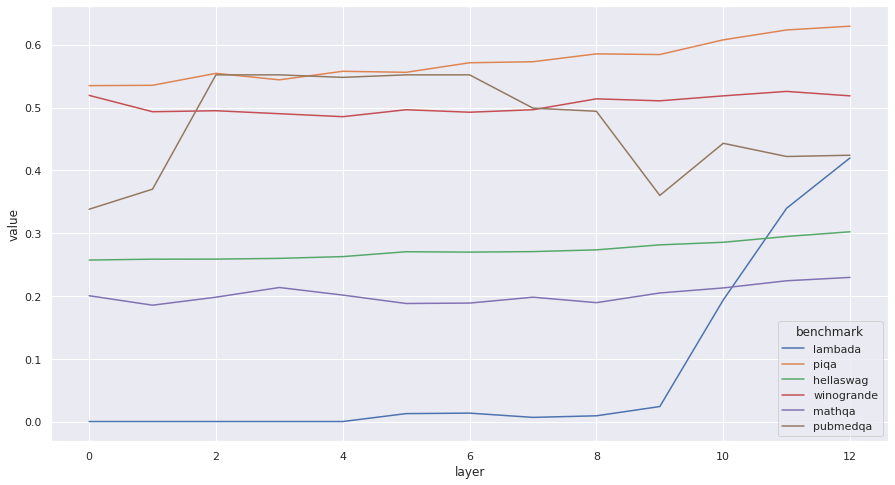

In [337]:
# Plot by steps
sns.set(rc = {'figure.figsize':(15,8)})

if False:
    bench = ["lambada", "piqa", "hellaswag", "winogrande", "mathqa", "pubmedqa"]
    data = r[(r["step"].notnull()) & (r["model"] == "dense_medium") & (r["benchmark"].isin(bench)) & (r["metric"] == "acc")]
    sns.lineplot(data=data, x="step", y="value", hue="benchmark")

# Plot by layers
if True:
    bench = ["lambada", "piqa", "hellaswag", "winogrande", "mathqa", "pubmedqa"]
    data = r[(r["layer"].notnull()) & (r["model"] == "dense_small") & (r["benchmark"].isin(bench)) & (r["metric"] == "acc")]
    sns.lineplot(data=data, x="layer", y="value", hue="benchmark")

In [338]:

# Plot by logit lens
bench = ["lambada", "piqa", "hellaswag", "winogrande", "mathqa", "pubmedqa"]
data = r[(r["lens"].notnull()) & (r["model"] == "dense_small") & (r["benchmark"].isin(bench)) & (r["metric"] == "acc")]
sns.lineplot(data=data, x="lens", y="value", hue="benchmark")

KeyError: 'lens'